# Predict customer retention by deep learning

# 1. Classify structured data with feature columns

## Dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn import model_selection,pipeline,compose,preprocessing
from tensorflow import feature_column
from tensorflow.keras import layers
# OOP python for feature engineering
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
path='https://raw.githubusercontent.com/rstudio/keras-customer-churn/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
dataframe=pd.read_csv(path)
dataframe.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
dataframe.shape

(7043, 21)

In [4]:
dataframe.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Create target variable

In [5]:
# In the original dataset "4" indicates the pet was not adopted. ( No need in this case)
#dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)
dataframe.rename(columns = {'Churn': 'target'}, inplace=True)
dataframe['target'] = np.where(dataframe['target']=="Yes", 1, 0)
# Drop un-used columns.
dataframe = dataframe.drop(columns=['customerID'])
# Convert total charge from object to float:
dataframe["TotalCharges"] = dataframe["TotalCharges"].replace(' ', np.nan).astype(float)
# Remove NA
dataframe.dropna(inplace=True)
dataframe.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [6]:
train, test = model_selection.train_test_split(dataframe, test_size=0.2)
train, val = model_selection.train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

4500 train examples
1125 validation examples
1407 test examples


Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [7]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [8]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size) # need suffle train ?
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [9]:
print(len(list(train_ds))) #902 batchs, each batch 5 sample --> 4507 sample
print(len(list(val_ds)))
print(len(list(test_ds)))

900
225
282


In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of MonthlyCharges:', train_features['MonthlyCharges'])
print('A batch of targets:', label_batch )

Every feature: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
A batch of MonthlyCharges: tf.Tensor([ 55.65  95.9   69.25 101.15 106.  ], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int64)


Demonstrate several types of feature columns

In [11]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]
example_batch # contain only x train, not include y train

{'gender': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Male', b'Male', b'Female', b'Female', b'Male'], dtype=object)>,
 'SeniorCitizen': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0])>,
 'Partner': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Yes', b'Yes', b'Yes', b'Yes', b'No'], dtype=object)>,
 'Dependents': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'No', b'Yes', b'Yes', b'Yes', b'No'], dtype=object)>,
 'tenure': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([29, 19, 71, 42,  2])>,
 'PhoneService': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Yes', b'Yes', b'Yes', b'Yes', b'Yes'], dtype=object)>,
 'MultipleLines': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Yes', b'Yes', b'Yes', b'No', b'No'], dtype=object)>,
 'InternetService': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Fiber optic', b'Fiber optic', b'No', b'Fiber optic', b'DSL'],
       dtype=object)>,
 'OnlineSecurity': <tf.Tensor: shape=(5,), dtype=stri

In [12]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

### Numeric columns
The output of a feature column becomes the input to the model (using the demo function defined above, we will be able to see exactly how each column from the dataframe is transformed). A [numeric column](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [13]:
example_batch['MonthlyCharges']

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 79.3 , 103.3 ,  24.7 ,  77.95,  45.85])>

In [14]:
MonthlyCharges = feature_column.numeric_column('MonthlyCharges') # feature column from tensorflow
MonthlyCharges

NumericColumn(key='MonthlyCharges', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [15]:
demo(MonthlyCharges) # show one sample from feature column

[[ 79.3 ]
 [103.3 ]
 [ 24.7 ]
 [ 77.95]
 [ 45.85]]


### Bucketized columns
Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

In [16]:
example_batch['MonthlyCharges']

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 79.3 , 103.3 ,  24.7 ,  77.95,  45.85])>

In [17]:
MonthlyCharges = feature_column.numeric_column('MonthlyCharges')
MonthlyCharges_buckets = feature_column.bucketized_column(MonthlyCharges, boundaries=[1, 50, 200])
MonthlyCharges_buckets

BucketizedColumn(source_column=NumericColumn(key='MonthlyCharges', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1, 50, 200))

In [18]:
demo(MonthlyCharges_buckets)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


### Categorical columns
In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using [categorical_column_with_vocabulary_list](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list), or loaded from a file using [categorical_column_with_vocabulary_file](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_file).

In [19]:
example_batch['PhoneService']

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Yes', b'Yes', b'Yes', b'Yes', b'Yes'], dtype=object)>

In [20]:
PhoneService_type = feature_column.categorical_column_with_vocabulary_list(
      'PhoneService', dataframe.PhoneService.unique())

PhoneService_type

VocabularyListCategoricalColumn(key='PhoneService', vocabulary_list=('No', 'Yes'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [21]:
PhoneService_type_one_hot = feature_column.indicator_column(PhoneService_type)
demo(PhoneService_type_one_hot)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### Embedding columns
Suppose instead of having just a few possible strings, we have thousands (or more) values per category. For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an [embedding column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.

Key point: using an embedding column is best when a categorical column has many possible values. We are using one here for demonstration purposes, so you have a complete example you can modify for a different dataset in the future.

In [22]:
example_batch['MultipleLines']

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Yes', b'Yes', b'Yes', b'No', b'No'], dtype=object)>

In [23]:
# Notice the input to the embedding column is the categorical column
# we previously created
MultipleLines = feature_column.categorical_column_with_vocabulary_list(
      'MultipleLines', dataframe.MultipleLines.unique())
MultipleLines_embedding = feature_column.embedding_column(MultipleLines, dimension=4)
demo(MultipleLines_embedding)

[[-0.16279511  0.09879851  0.21911593  0.7444544 ]
 [-0.16279511  0.09879851  0.21911593  0.7444544 ]
 [-0.16279511  0.09879851  0.21911593  0.7444544 ]
 [-0.8048785  -0.280345   -0.19256836  0.25964463]
 [-0.8048785  -0.280345   -0.19256836  0.25964463]]


### Hashed feature columns

Another way to represent a categorical column with a large number of values is to use a [categorical_column_with_hash_bucket](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_hash_bucket). This feature column calculates a hash value of the input, then selects one of the `hash_bucket_size` buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

Key point: An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some datasets regardless.

In [24]:
MultipleLines_hashed = feature_column.categorical_column_with_hash_bucket(
      'MultipleLines', hash_bucket_size=10)
demo(feature_column.indicator_column(MultipleLines_hashed))

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


### Crossed feature columns
Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of Age and Type. Note that `crossed_column` does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a `hashed_column`, so you can choose how large the table is.

In [25]:
demo(MonthlyCharges_buckets)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [26]:
PhoneService_type_one_hot = feature_column.indicator_column(PhoneService_type)
demo(PhoneService_type_one_hot)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [27]:
#crossed_feature = feature_column.crossed_column([MonthlyCharges_buckets, PhoneService_type], hash_bucket_size=10)
#demo(feature_column.indicator_column(crossed_feature))

## Choose which columns to use
We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

In [28]:
#train.head()

dataframe_remove_target = dataframe.iloc[:,:-1]
dataframe_remove_target.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [29]:
numerical_column =list(dataframe_remove_target.select_dtypes('number').columns)

In [30]:
feature_columns = []
# numeric cols
for header in numerical_column:
  feature_columns.append(feature_column.numeric_column(header))

In [31]:
# bucketized cols (bin numeric column, suggest for monthly charge and total charge)
#age = feature_column.numeric_column('Age')
#age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
#feature_columns.append(age_buckets)

In [32]:
# indicator_columns (for category)
categorical_column = list(dataframe_remove_target.select_dtypes('object').columns) # Remove target column
for col_name in categorical_column:
  categorical_column = feature_column.categorical_column_with_vocabulary_list( col_name, dataframe_remove_target[col_name].unique()) # Define One hot encoder
  indicator_column = feature_column.indicator_column(categorical_column) # convert to one hot
  feature_columns.append(indicator_column)

In [33]:
# embedding columns (for category with a lot of unique item, not apply here)
#breed1 = feature_column.categorical_column_with_vocabulary_list(
#      'Breed1', dataframe.Breed1.unique())
#breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
#feature_columns.append(breed1_embedding)

In [34]:
# crossed columns (no need here)
#age_type_feature = feature_column.crossed_column([age_buckets, animal_type], #hash_bucket_size=100)
#feature_columns.append(feature_column.indicator_column(age_type_feature))

In [35]:
feature_columns

[NumericColumn(key='SeniorCitizen', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='tenure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MonthlyCharges', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='TotalCharges', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='gender', vocabulary_list=('Female', 'Male'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Partner', vocabulary_list=('Yes', 'No'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Dependents', vocabulary_list=('No', 'Yes'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalC

Now that we have defined our feature columns, we will use a DenseFeatures layer to input them to our Keras model.

In [36]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [37]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Create, compile, and train the model

In [38]:
train.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
target                int64
dtype: object

In [78]:
tf.keras.backend.set_floatx('float64') ## remove warning : Sequential model should only have a single input tensor, but we receive a <class 'dict'> 
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #metrics=METRICS
              metrics=['accuracy']
              )

In [79]:

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
137/141 [============================>.] - ETA: 0s - loss: 30.7005 - accuracy: 0.6472WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'gender': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=string>, 'SeniorCitizen': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=int64>, 'Partner': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'Dependents': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'tenure': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=int64>, 'PhoneService': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'MultipleLines': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'InternetService': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'OnlineSecurity': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=string>, '

In [91]:
model.history["loss"]

TypeError: 'History' object is not subscriptable

In [88]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(model):
  # plot training error and test error
  fig,(ax1,ax2)=plt.subplots(1,2)
  ax1.plot(model.history['loss'],label='train loss')
  ax1.plot(model.history['val_loss'],label='validation loss')
  ax2.plot(model.history['accuracy'],label='train accuracy')
  ax2.plot(model.history['val_accuracy'],label='validation accuracy')

  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend()

  ax2.set(xlabel='epoch', ylabel='accuracy')
  ax2.set_ylim([0, 1])
  ax2.legend()
  plt.tight_layout()
  #plt.legend(['train loss', 'validation loss','train_accuracy','val_accuracy'], loc='lower right')



TypeError: 'History' object is not subscriptable

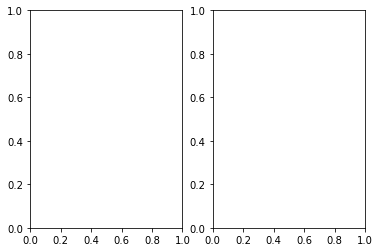

In [89]:
plot_loss_accuracy(model)

In [62]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

44/44 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.7747
Accuracy 0.7746979388770433


In [68]:
test_ds

<BatchDataset shapes: ({gender: (None,), SeniorCitizen: (None,), Partner: (None,), Dependents: (None,), tenure: (None,), PhoneService: (None,), MultipleLines: (None,), InternetService: (None,), OnlineSecurity: (None,), OnlineBackup: (None,), DeviceProtection: (None,), TechSupport: (None,), StreamingTV: (None,), StreamingMovies: (None,), Contract: (None,), PaperlessBilling: (None,), PaymentMethod: (None,), MonthlyCharges: (None,), TotalCharges: (None,)}, (None,)), types: ({gender: tf.string, SeniorCitizen: tf.int64, Partner: tf.string, Dependents: tf.string, tenure: tf.int64, PhoneService: tf.string, MultipleLines: tf.string, InternetService: tf.string, OnlineSecurity: tf.string, OnlineBackup: tf.string, DeviceProtection: tf.string, TechSupport: tf.string, StreamingTV: tf.string, StreamingMovies: tf.string, Contract: tf.string, PaperlessBilling: tf.string, PaymentMethod: tf.string, MonthlyCharges: tf.float64, TotalCharges: tf.float64}, tf.int64)>

In [65]:
y_pred=np.argmax(model.predict(test_ds), axis=-1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
y_pred=model.predict(X_test)
y_pred_probs=model.predict_proba(X_test)
print(metrics.confusion_matrix(y_test,y_pred))
print('Balanced Accuracy score:',metrics.balanced_accuracy_score(y_test,y_pred))
print('f1 macro score:',metrics.f1_score(y_test,y_pred,average="macro")) # good for imbalance dataset
print('precision macro score:',metrics.precision_score(y_test,y_pred,average="macro"))
print('recall macro score:',metrics.recall_score(y_test,y_pred,average="macro"))
#fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:,1],pos_label='Yes') # convert label to yes/no
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:,1])
print("AUC:",metrics.auc(fpr, tpr))
print("MCC:",metrics.matthews_corrcoef(y_test,y_pred))
print(classification_report(y_test,y_pred))

NameError: name 'X_test' is not defined

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_7 (DenseFeatu multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5888      
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  129       
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


Key point: You will typically see best results with deep learning with much larger and more complex datasets. When working with a small dataset like this one, we recommend using a decision tree or random forest as a strong baseline. The goal of this tutorial is not to train an accurate model, but to demonstrate the mechanics of working with structured data, so you have code to use as a starting point when working with your own datasets in the future.